In [20]:
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import math

In [12]:
ev_df = pd.read_csv("../data/eVED_181107_week.csv")
ev_df.head(35)

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],...,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Intersection,Bus Stops,Focus Points
0,372.882455,10.0,3263.0,0.0,42.295477,-83.705005,32.079998,NaN,NaN,NaN,...,0.004811,42.295487,-83.704927,0,0.0,64,64.0,NaN,NaN,NaN
1,372.882455,10.0,3263.0,900.0,42.295477,-83.705005,35.730000,NaN,NaN,NaN,...,0.004811,42.295487,-83.704927,1,0.0,64,64.0,NaN,NaN,NaN
2,372.882455,10.0,3263.0,1100.0,42.295477,-83.705005,35.730000,NaN,NaN,NaN,...,0.005334,42.295487,-83.704927,1,0.0,64,64.0,NaN,NaN,NaN
3,372.882455,10.0,3263.0,2000.0,42.295477,-83.705005,38.770000,NaN,NaN,NaN,...,0.005334,42.295487,-83.704927,1,0.0,64,64.0,NaN,NaN,NaN
4,372.882455,10.0,3263.0,2100.0,42.295477,-83.705005,38.770000,NaN,NaN,NaN,...,0.005857,42.295487,-83.704927,1,0.0,64,64.0,NaN,NaN,NaN
5,372.882455,10.0,3263.0,2900.0,42.295199,-83.704957,38.770000,NaN,NaN,NaN,...,0.005857,42.295202,-83.704876,0,0.0,64,64.0,NaN,NaN,NaN
6,372.882455,10.0,3263.0,3100.0,42.295199,-83.704957,42.889999,NaN,NaN,NaN,...,0.005857,42.295202,-83.704876,1,0.0,64,64.0,NaN,NaN,NaN
7,372.882455,10.0,3263.0,3200.0,42.295199,-83.704957,42.889999,NaN,NaN,NaN,...,0.006327,42.295202,-83.704876,1,0.0,64,64.0,NaN,NaN,NaN
8,372.882455,10.0,3263.0,4200.0,42.295199,-83.704957,46.450001,NaN,NaN,NaN,...,0.006327,42.295202,-83.704876,1,0.0,64,64.0,NaN,NaN,NaN
9,372.882455,10.0,3263.0,4800.0,42.295199,-83.704957,46.450001,NaN,NaN,NaN,...,0.006294,42.295202,-83.704876,1,0.0,64,64.0,NaN,NaN,NaN


In [26]:
def haversine(lat1, lon1, lat2, lon2):
    # Earth radius in kilometers
    R = 6371.0
    
    # Convert degrees to radians
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi / 2.0)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c
    return distance

4.12427097693259


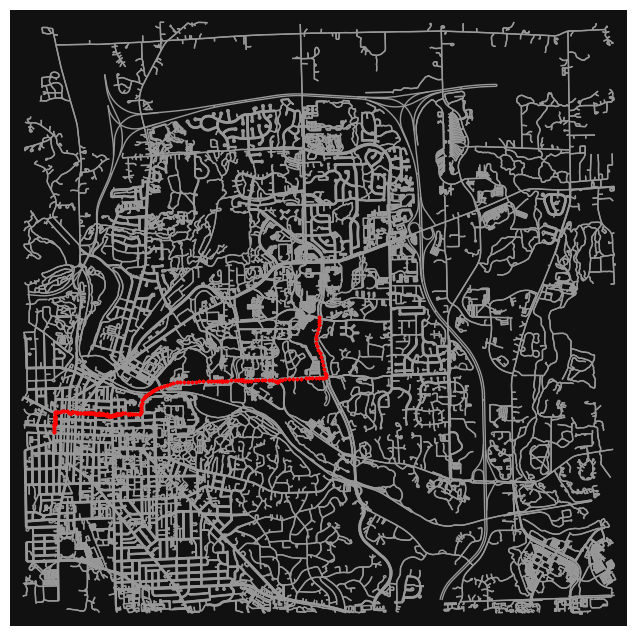

In [30]:
def get_trip_outline(df, trip_id):
    # Filter the dataframe for the specific trip and timestamps
    trip_max_time = ev_df[(ev_df['Trip'] == trip_id)]['Timestamp(ms)'].max()
    trip_data = ev_df[(ev_df['Trip'] == trip_id) & 
        (ev_df['Timestamp(ms)'] >= 0) & 
        (ev_df['Timestamp(ms)'] <= trip_max_time)]

    # Extract the latitude and longitude values
    latitudes = trip_data['Latitude[deg]'].values
    longitudes = trip_data['Longitude[deg]'].values

    trip_dist = haversine(latitudes[0], longitudes[0], latitudes[-1], longitudes[-1])
    print(trip_dist)
    # Create a map centered around the first point
    map_center = (latitudes[0], longitudes[0])
    G = ox.graph_from_point(map_center, dist=trip_dist*1000 + 100, network_type='all')

    # Plot the map with the points
    fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)
    ax.scatter(longitudes, latitudes, c='red', s=2, zorder=2)
    plt.show()

get_trip_outline(ev_df, 3263)